# Smets & Wouters (2007) - Replicación de Figura 4

Este notebook replica la **Figura 4** del paper "Shocks and Frictions in US Business Cycles: A Bayesian DSGE Approach" (AER, 2007).

**Figura 4**: Historical Decomposition of GDP Growth and Inflation
- Panel A: Annual per capita GDP growth (deviation from trend growth)
- Panel B: Inflation (deviation from mean)

La descomposición histórica muestra la contribución de cada shock estructural a los movimientos observados de estas variables durante el período de muestra (1966:Q1 - 2004:Q4).

**Nota sobre `mh_replic=0`:**
- Este parámetro NO afecta la descomposición histórica de shocks
- Solo significa que se usa el modo posterior (sin MCMC), lo cual es más rápido
- El smoother de Kalman funciona correctamente con el modo posterior

**Requisitos previos:**
- GNU Octave instalado y en PATH
- Dynare 6.x instalado
- Archivo `usmodel_mode.mat` con posterior mode

## 1. Setup y Configuración

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

# Add parent directory to path
sys.path.append(str(Path.cwd().parent.parent))

from direct_replication import DynareInterface

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Imports completados")

Imports completados


In [2]:
# Configurar rutas - MODIFICAR SEGUN TU INSTALACION

# Configurar ruta de Octave (necesario en Windows)
os.environ['OCTAVE_EXECUTABLE'] = r'C:\Program Files\GNU Octave\Octave-10.3.0\mingw64\bin\octave-cli.exe'

DYNARE_PATH = r'C:\dynare\6.5\matlab'  # Ruta a carpeta matlab de Dynare
REPO_PATH = Path.cwd().parent.parent / 'repo'  # Carpeta con datos (.xls)
MODEL_PATH = Path.cwd().parent / 'model'  # Carpeta con .mod files

print(f"Octave executable: {os.environ['OCTAVE_EXECUTABLE']}")
print(f"Dynare path: {DYNARE_PATH}")
print(f"Repo path: {REPO_PATH}")
print(f"Model path: {MODEL_PATH}")
print(f"Repo exists: {REPO_PATH.exists()}")
print(f"Model exists: {MODEL_PATH.exists()}")

Octave executable: C:\Program Files\GNU Octave\Octave-10.3.0\mingw64\bin\octave-cli.exe
Dynare path: C:\dynare\6.5\matlab
Repo path: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\repo
Model path: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\direct_replication\model
Repo exists: True
Model exists: True


### Test de Conexión Octave + Dynare

In [3]:
from oct2py import Oct2Py

# Test basico
try:
    oc = Oct2Py()
    result = oc.eval('2 + 2', nout=1)
    print(f"Octave conectado: 2 + 2 = {result}")
    
    # Test Dynare
    oc.addpath(DYNARE_PATH)
    dynare_exists = oc.eval('exist("dynare")', nout=1)
    if dynare_exists == 2:
        print("Dynare encontrado")
    else:
        print("Dynare NO encontrado - verificar DYNARE_PATH")
    
    oc.exit()
    print("\nTodo listo!")
    
except Exception as e:
    print(f"Error: {e}")
    print("Ver setup_instructions.md para solucion de problemas")

Octave conectado: 2 + 2 = 4.0
    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

Dynare encontrado

Todo listo!


## 2. Configuración para Figura 4

### Shocks estructurales del modelo:
- **Supply shocks:** Productivity (ea), Price markup (epinf), Wage markup (ew)
- **Demand shocks:** Risk premium (eb), Government spending (eg), Investment (eqs), Monetary (em)

In [4]:
# Definiciones para Figura 4

# Labels para los 7 shocks estructurales
SHOCK_LABELS = {
    'ea': 'Productivity',
    'eb': 'Risk premium',
    'eg': 'Exog. spending',
    'eqs': 'Investment',
    'em': 'Monetary',
    'epinf': 'Price markup',
    'ew': 'Wage markup'
}

SHOCK_ORDER = ['ea', 'eb', 'eg', 'eqs', 'em', 'epinf', 'ew']

# Variables para Figura 4
FIGURE4_VARIABLES = ['dy', 'pinfobs']
FIGURE4_LABELS = {
    'dy': 'GDP Growth',
    'pinfobs': 'Inflation'
}

# Período de muestra
# first_obs=71 en usmodel = 1966:Q1 (dato 71 de 231 observaciones desde 1947:Q3)
START_YEAR = 1966
START_QUARTER = 1

# Colores para los shocks (consistente con otras figuras)
SHOCK_COLORS = {
    'ea': '#1f77b4',      # Azul - Productivity
    'eb': '#ff7f0e',      # Naranja - Risk premium
    'eg': '#2ca02c',      # Verde - Gov spending
    'eqs': '#d62728',     # Rojo - Investment
    'em': '#9467bd',      # Púrpura - Monetary
    'epinf': '#8c564b',   # Marrón - Price markup
    'ew': '#e377c2'       # Rosa - Wage markup
}

print("Configuración de Figura 4 definida")
print(f"\nVariables: {FIGURE4_VARIABLES}")
print(f"Shocks: {SHOCK_ORDER}")
print(f"Período: {START_YEAR}:Q{START_QUARTER} - 2004:Q4")

Configuración de Figura 4 definida

Variables: ['dy', 'pinfobs']
Shocks: ['ea', 'eb', 'eg', 'eqs', 'em', 'epinf', 'ew']
Período: 1966:Q1 - 2004:Q4


## 3. Ejecutar Dynare con Modelo para Figura 4

Usamos `usmodel_figure4.mod` que tiene:
- `smoother` en estimation para ejecutar el Kalman smoother
- `shock_decomposition` para calcular la descomposición histórica
- `mh_replic=0` para usar solo el modo posterior (sin MCMC)

In [5]:
# Inicializar interfaz Dynare
di = DynareInterface(DYNARE_PATH, str(MODEL_PATH))

print("Interfaz Dynare inicializada")

    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

Interfaz Dynare inicializada


In [6]:
# Ejecutar modelo para Figura 4
# Este modelo incluye smoother y shock_decomposition

print("Ejecutando usmodel_figure4.mod...")
print("(Esto puede tardar varios minutos)\n")
print("Nota: mh_replic=0 significa que se usa el modo posterior sin MCMC.")
print("Esto NO afecta la descomposición histórica de shocks.\n")

di.run_model('usmodel_figure4.mod')

print("\nDynare completado")

Ejecutando usmodel_figure4.mod...
(Esto puede tardar varios minutos)

Nota: mh_replic=0 significa que se usa el modo posterior sin MCMC.
Esto NO afecta la descomposición histórica de shocks.


Step 1: Closing Octave session to release file locks...
Waiting for Windows to release file handles...

Step 2: Cleaning up directories...
Searching for directories to clean up...
No directories found to clean up.

Step 3: Starting fresh Octave session...
    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

✓ Octave session ready

Step 4: Running Dynare estimation...
Command: dynare usmodel_figure4 nograph
(This may take several minutes...)

Starting Dynare (version 6.5).
Calling Dynare with arguments: nograph
Starting preprocessing of the model file ...
Found 40 equation(s).
Evaluating expressions...
Computing static model derivatives (order 1).
Normalizing the static model...
Finding the optimal block decomposition of the static model...
11 block

## 4. Extraer Historical Shock Decomposition

La descomposición histórica muestra cómo cada shock estructural contribuyó a los movimientos observados de las variables durante el período de muestra.

In [7]:
def extract_shock_decomposition_figure4(di, variables=['dy', 'pinfobs']):
    """
    Extrae la descomposición histórica de shocks de Dynare.
    
    En Dynare, oo_.shock_decomposition tiene dimensiones:
    (n_endo_vars x (n_shocks + 2) x n_periods)
    
    - Columnas 1 a n_shocks: contribución de cada shock
    - Columna n_shocks+1: contribución de condiciones iniciales
    - Columna n_shocks+2: variable suavizada (smoothed)
    
    Returns:
        DataFrame con columnas: variable, shock, period, year, quarter, contribution
    """
    # Verificar que existe shock_decomposition
    has_decomp = di.oc.eval('isfield(oo_, "shock_decomposition")', nout=1)
    if not has_decomp:
        raise RuntimeError("Shock decomposition no encontrada. Verificar que shock_decomposition se ejecutó.")
    
    # Obtener dimensiones
    decomp_size = di.oc.eval('size(oo_.shock_decomposition)', nout=1)
    decomp_size = np.array(decomp_size).flatten()
    n_vars = int(decomp_size[0])
    n_cols = int(decomp_size[1])
    n_periods = int(decomp_size[2])
    n_shocks = n_cols - 2  # Últimas 2 columnas son initial + smoothed
    
    print(f"Shock decomposition dimensions: {n_vars} vars x {n_cols} cols x {n_periods} periods")
    print(f"Number of shocks: {n_shocks}")
    print(f"Number of periods: {n_periods}")
    
    # Obtener nombres de variables endógenas (orden de declaración en var)
    endo_names_raw = di.oc.eval('M_.endo_names', nout=1)
    # Convertir a lista de strings
    if hasattr(endo_names_raw, 'tolist'):
        endo_names = [str(n).strip() for n in endo_names_raw.flatten()]
    else:
        endo_names = [str(n).strip() for n in endo_names_raw]
    
    # Nombres de shocks (orden de varexo)
    shock_names = ['ea', 'eb', 'eg', 'eqs', 'em', 'epinf', 'ew']
    
    print(f"\nEndogenous variables ({len(endo_names)}): {endo_names[:10]}...")
    print(f"Shocks: {shock_names}")
    
    # Encontrar índices de las variables de interés
    var_indices = {}
    for var in variables:
        try:
            idx = endo_names.index(var)
            var_indices[var] = idx
            print(f"Variable '{var}' encontrada en índice {idx}")
        except ValueError:
            print(f"WARNING: Variable '{var}' no encontrada en M_.endo_names")
    
    # Extraer array
    decomp_array = di.oc.eval('oo_.shock_decomposition', nout=1)
    print(f"\nShock decomposition array shape: {decomp_array.shape}")
    
    # Construir DataFrame
    data = []
    for var, v_idx in var_indices.items():
        for t in range(n_periods):
            # Calcular fecha
            total_quarters = (START_QUARTER - 1) + t
            year = START_YEAR + total_quarters // 4
            quarter = (total_quarters % 4) + 1
            
            # Contribución de cada shock
            for s_idx, shock in enumerate(shock_names):
                contribution = float(decomp_array[v_idx, s_idx, t])
                data.append({
                    'variable': var,
                    'shock': shock,
                    'period': t + 1,
                    'year': year,
                    'quarter': quarter,
                    'quarter_date': f"{year}Q{quarter}",
                    'contribution': contribution
                })
            
            # Condiciones iniciales (columna n_shocks)
            initial_contrib = float(decomp_array[v_idx, n_shocks, t])
            data.append({
                'variable': var,
                'shock': 'initial',
                'period': t + 1,
                'year': year,
                'quarter': quarter,
                'quarter_date': f"{year}Q{quarter}",
                'contribution': initial_contrib
            })
            
            # Variable suavizada (columna n_shocks + 1)
            smoothed_value = float(decomp_array[v_idx, n_shocks + 1, t])
            data.append({
                'variable': var,
                'shock': 'smoothed',
                'period': t + 1,
                'year': year,
                'quarter': quarter,
                'quarter_date': f"{year}Q{quarter}",
                'contribution': smoothed_value
            })
    
    return pd.DataFrame(data)

# Extraer shock decomposition
print("Extrayendo Historical Shock Decomposition...\n")
shock_decomp_df = extract_shock_decomposition_figure4(di, FIGURE4_VARIABLES)

print(f"\nShock decomposition extraída: {len(shock_decomp_df)} filas")
print(f"Variables: {shock_decomp_df['variable'].unique()}")
print(f"Shocks: {shock_decomp_df['shock'].unique()}")

Extrayendo Historical Shock Decomposition...

Shock decomposition dimensions: 40 vars x 9 cols x 160 periods
Number of shocks: 7
Number of periods: 160

Endogenous variables (40): ['labobs', 'robs', 'pinfobs', 'dy', 'dc', 'dinve', 'dw', 'ewma', 'epinfma', 'zcapf']...
Shocks: ['ea', 'eb', 'eg', 'eqs', 'em', 'epinf', 'ew']
Variable 'dy' encontrada en índice 3
Variable 'pinfobs' encontrada en índice 2

Shock decomposition array shape: (40, 9, 160)

Shock decomposition extraída: 2880 filas
Variables: ['dy' 'pinfobs']
Shocks: ['ea' 'eb' 'eg' 'eqs' 'em' 'epinf' 'ew' 'initial' 'smoothed']


In [8]:
# Verificar que la suma de contribuciones = variable suavizada
print("Verificando consistencia de la descomposición...\n")

for var in FIGURE4_VARIABLES:
    var_data = shock_decomp_df[shock_decomp_df['variable'] == var]
    
    # Tomar algunos períodos de muestra
    for period in [1, 50, 100]:
        if period > var_data['period'].max():
            continue
            
        period_data = var_data[var_data['period'] == period]
        
        # Suma de shocks + initial
        shocks_sum = period_data[period_data['shock'].isin(SHOCK_ORDER + ['initial'])]['contribution'].sum()
        
        # Valor suavizado
        smoothed = period_data[period_data['shock'] == 'smoothed']['contribution'].values[0]
        
        diff = abs(shocks_sum - smoothed)
        status = "OK" if diff < 0.01 else "CHECK"
        
        quarter_date = period_data['quarter_date'].values[0]
        print(f"  {var} t={period} ({quarter_date}): Sum={shocks_sum:.4f}, Smoothed={smoothed:.4f}, Diff={diff:.6f} [{status}]")

print("\nVerificación completada")

Verificando consistencia de la descomposición...

  dy t=1 (1966Q1): Sum=1.5763, Smoothed=1.5763, Diff=0.000000 [OK]
  dy t=50 (1978Q2): Sum=1.0440, Smoothed=1.0440, Diff=0.000000 [OK]
  dy t=100 (1990Q4): Sum=-0.4013, Smoothed=-0.4013, Diff=0.000000 [OK]
  pinfobs t=1 (1966Q1): Sum=-0.3119, Smoothed=-0.3119, Diff=0.000000 [OK]
  pinfobs t=50 (1978Q2): Sum=0.6191, Smoothed=0.6191, Diff=0.000000 [OK]
  pinfobs t=100 (1990Q4): Sum=-0.1282, Smoothed=-0.1282, Diff=0.000000 [OK]

Verificación completada


In [9]:
# Mostrar primeras filas
print("Primeras filas de la descomposición:")
shock_decomp_df.head(20)

Primeras filas de la descomposición:


,variable,shock,period,year,quarter,quarter_date,contribution
0,dy,ea,1,1966,1,1966Q1,-0.033031
1,dy,eb,1,1966,1,1966Q1,-0.067276
2,dy,eg,1,1966,1,1966Q1,0.173275
3,dy,eqs,1,1966,1,1966Q1,0.037788
4,dy,em,1,1966,1,1966Q1,-0.006238
5,dy,epinf,1,1966,1,1966Q1,0.010226
6,dy,ew,1,1966,1,1966Q1,-0.002704
7,dy,initial,1,1966,1,1966Q1,1.464258
8,dy,smoothed,1,1966,1,1966Q1,1.576298
9,dy,ea,2,1966,2,1966Q2,-0.016416


## 5. Convertir Datos Trimestrales a Anuales

La Figura 4 del paper muestra datos ANUALES (barras por año). Necesitamos convertir tanto GDP growth como Inflation de trimestral a anual.

In [10]:
def compute_annual_decomposition(shock_decomp_df, variable):
    """
    Convierte la descomposición trimestral a anual.
    
    Para tasas de crecimiento (dy), el crecimiento anual es aproximadamente
    la suma de los 4 crecimientos trimestrales.
    
    Para inflación (pinfobs), tomamos el promedio anual.
    
    Returns:
        DataFrame con descomposición anual
    """
    var_data = shock_decomp_df[shock_decomp_df['variable'] == variable].copy()
    
    # Agrupar por año y shock
    # Para GDP growth: sumar los 4 trimestres
    # Para Inflation: promediar los 4 trimestres
    if variable == 'dy':
        annual_data = var_data.groupby(['year', 'shock']).agg({
            'contribution': 'sum'
        }).reset_index()
    else:
        annual_data = var_data.groupby(['year', 'shock']).agg({
            'contribution': 'mean'
        }).reset_index()
    
    annual_data['variable'] = variable
    
    return annual_data

# Calcular descomposición anual para ambas variables
annual_gdp_decomp = compute_annual_decomposition(shock_decomp_df, 'dy')
annual_inf_decomp = compute_annual_decomposition(shock_decomp_df, 'pinfobs')

print(f"Descomposición anual de GDP growth: {len(annual_gdp_decomp)} filas")
print(f"Descomposición anual de Inflation: {len(annual_inf_decomp)} filas")
print(f"Años: {annual_gdp_decomp['year'].min()} - {annual_gdp_decomp['year'].max()}")

# Mostrar ejemplo para 1975 (recesión)
print("\nEjemplo GDP Growth 1975 (recesión):")
print(annual_gdp_decomp[annual_gdp_decomp['year'] == 1975][['shock', 'contribution']].to_string(index=False))

print("\nEjemplo Inflation 1975:")
print(annual_inf_decomp[annual_inf_decomp['year'] == 1975][['shock', 'contribution']].to_string(index=False))

Descomposición anual de GDP growth: 360 filas
Descomposición anual de Inflation: 360 filas
Años: 1966 - 2005

Ejemplo GDP Growth 1975 (recesión):
   shock  contribution
      ea     -1.575834
      eb     -1.200370
      eg      0.402915
      em      0.288453
   epinf     -1.879300
     eqs     -0.665498
      ew     -1.162638
 initial      0.095514
smoothed     -5.696758

Ejemplo Inflation 1975:
   shock  contribution
      ea      0.077598
      eb     -0.001900
      eg      0.018011
      em     -0.037176
   epinf      0.552146
     eqs      0.098500
      ew      0.919280
 initial      0.071890
smoothed      1.698350


## 6. Calcular Desviaciones de la Media

El paper muestra las desviaciones respecto a la tendencia/media. Para el modelo linealizado, las variables ya están en desviación del estado estacionario.

In [11]:
# Verificar la media de las variables suavizadas
print("Estadísticas de las variables suavizadas (deviation from steady state):\n")

for var in FIGURE4_VARIABLES:
    smoothed_data = shock_decomp_df[
        (shock_decomp_df['variable'] == var) & 
        (shock_decomp_df['shock'] == 'smoothed')
    ]['contribution']
    
    print(f"{FIGURE4_LABELS[var]}:")
    print(f"  Mean: {smoothed_data.mean():.4f}")
    print(f"  Std:  {smoothed_data.std():.4f}")
    print(f"  Min:  {smoothed_data.min():.4f}")
    print(f"  Max:  {smoothed_data.max():.4f}")
    print()

Estadísticas de las variables suavizadas (deviation from steady state):

GDP Growth:
  Mean: 0.0084
  Std:  0.8707
  Min:  -2.8611
  Max:  3.0006

Inflation:
  Mean: 0.1752
  Std:  0.6129
  Min:  -0.6582
  Max:  2.1297



## 7. Graficar Figura 4: Historical Decomposition (ANUAL)

Creamos gráficos de **barras apiladas por año** mostrando la contribución de cada shock a los movimientos históricos de GDP growth e Inflation, tal como aparece en el paper original.

In [12]:
def plot_annual_decomposition_panel(annual_decomp, shock_order, shock_labels, shock_colors, 
                                     title, ylabel, ax):
    """
    Grafica la descomposición anual como barras apiladas (estilo paper S&W 2007).
    
    Args:
        annual_decomp: DataFrame con descomposición anual
        shock_order: Orden de los shocks
        shock_labels: Labels para los shocks
        shock_colors: Colores para los shocks
        title: Título del panel
        ylabel: Label del eje Y
        ax: Matplotlib axes
    """
    years = sorted(annual_decomp['year'].unique())
    # Excluir 2005 si solo tiene datos parciales
    years = [y for y in years if y <= 2004]
    
    shocks_to_plot = shock_order + ['initial']
    colors = [shock_colors.get(s, '#888888') for s in shocks_to_plot]
    labels = [shock_labels.get(s, s) for s in shocks_to_plot]
    labels[-1] = 'Initial'
    
    # Preparar matriz de contribuciones
    contrib_matrix = np.zeros((len(shocks_to_plot), len(years)))
    for s_idx, shock in enumerate(shocks_to_plot):
        for y_idx, year in enumerate(years):
            val = annual_decomp[(annual_decomp['year'] == year) & (annual_decomp['shock'] == shock)]['contribution']
            if len(val) > 0:
                contrib_matrix[s_idx, y_idx] = val.values[0]
    
    bar_width = 0.8
    x_pos = np.arange(len(years))
    
    # Apilar barras separando positivos y negativos
    bottom_pos = np.zeros(len(years))
    bottom_neg = np.zeros(len(years))
    
    for s_idx, shock in enumerate(shocks_to_plot):
        values = contrib_matrix[s_idx, :]
        pos_vals = np.maximum(values, 0)
        neg_vals = np.minimum(values, 0)
        
        ax.bar(x_pos, pos_vals, bar_width, bottom=bottom_pos,
               color=colors[s_idx], label=labels[s_idx], alpha=0.85, edgecolor='white', linewidth=0.3)
        bottom_pos += pos_vals
        
        ax.bar(x_pos, neg_vals, bar_width, bottom=bottom_neg,
               color=colors[s_idx], alpha=0.85, edgecolor='white', linewidth=0.3)
        bottom_neg += neg_vals
    
    # Línea del valor observado/suavizado
    smoothed = annual_decomp[annual_decomp['shock'] == 'smoothed'].copy()
    smoothed = smoothed[smoothed['year'] <= 2004].sort_values('year')
    if len(smoothed) == len(years):
        ax.plot(x_pos, smoothed['contribution'].values, 'k-', linewidth=2, label='Actual', zorder=10)
    
    # Formato
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=10)
    
    # Eje X: mostrar cada 5 años
    tick_positions = x_pos[::5]
    tick_labels = [str(years[i]) for i in range(0, len(years), 5)]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, fontsize=9)
    ax.set_xlim(-0.5, len(years) - 0.5)
    
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    
    return ax

Generando Figura 4: Historical Decomposition (ANUAL)...



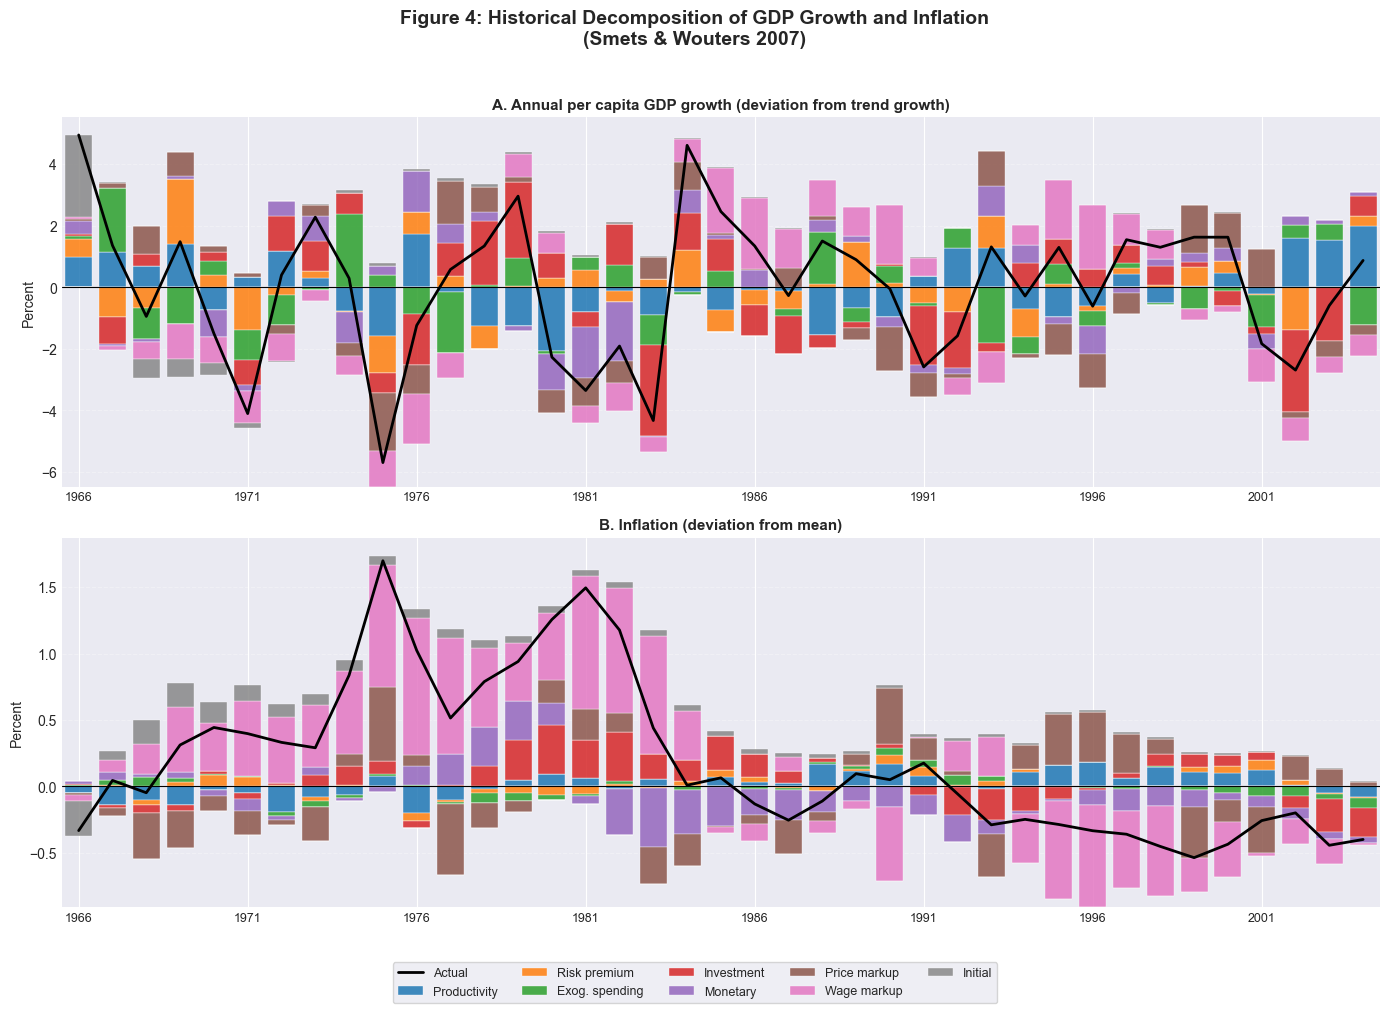


Figura 4 (ANUAL) generada


In [13]:
# Generar Figura 4 completa (ANUAL - como en el paper)
print("Generando Figura 4: Historical Decomposition (ANUAL)...\n")

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Panel A: GDP Growth (anual)
plot_annual_decomposition_panel(
    annual_gdp_decomp,
    SHOCK_ORDER,
    SHOCK_LABELS,
    SHOCK_COLORS,
    'A. Annual per capita GDP growth (deviation from trend growth)',
    'Percent',
    axes[0]
)

# Panel B: Inflation (anual)
plot_annual_decomposition_panel(
    annual_inf_decomp,
    SHOCK_ORDER,
    SHOCK_LABELS,
    SHOCK_COLORS,
    'B. Inflation (deviation from mean)',
    'Percent',
    axes[1]
)

# Leyenda compartida abajo
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=9, 
           bbox_to_anchor=(0.5, -0.02), frameon=True)

plt.suptitle('Figure 4: Historical Decomposition of GDP Growth and Inflation\n(Smets & Wouters 2007)', 
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.96])

fig4 = fig
plt.show()

print("\nFigura 4 (ANUAL) generada")

## 8. Exportar Resultados

In [14]:
# Guardar figura
output_dir = Path.cwd()

fig4.savefig(output_dir / 'figure4_historical_decomposition.png', dpi=300, bbox_inches='tight')
print(f"Figura 4 guardada en: {output_dir / 'figure4_historical_decomposition.png'}")

# Guardar datos en CSV
# Datos anuales de GDP growth
annual_gdp_decomp.to_csv(output_dir / 'figure4_gdp_annual_decomposition.csv', index=False)
print(f"Datos GDP anual guardados en: {output_dir / 'figure4_gdp_annual_decomposition.csv'}")

# Datos anuales de Inflation
annual_inf_decomp.to_csv(output_dir / 'figure4_inflation_annual_decomposition.csv', index=False)
print(f"Datos Inflation anual guardados en: {output_dir / 'figure4_inflation_annual_decomposition.csv'}")

# Datos trimestrales originales (por si se necesitan)
shock_decomp_df.to_csv(output_dir / 'figure4_quarterly_decomposition.csv', index=False)
print(f"Datos trimestrales guardados en: {output_dir / 'figure4_quarterly_decomposition.csv'}")

Figura 4 guardada en: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\direct_replication\notebooks\figure4_historical_decomposition.png
Datos GDP anual guardados en: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\direct_replication\notebooks\figure4_gdp_annual_decomposition.csv
Datos Inflation anual guardados en: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\direct_replication\notebooks\figure4_inflation_annual_decomposition.csv
Datos trimestrales guardados en: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\direct_replication\notebooks\figure4_quarterly_decomposition.csv


## 9. Resumen de Resultados

In [15]:
# Resumen de contribuciones por shock (datos anuales)
print("="*70)
print("RESUMEN: Contribución promedio de cada shock (ANUAL)")
print("="*70)

print("\nGDP Growth (suma anual de contribuciones trimestrales):")
print("-" * 50)
for shock in SHOCK_ORDER:
    shock_data = annual_gdp_decomp[annual_gdp_decomp['shock'] == shock]['contribution']
    print(f"  {SHOCK_LABELS[shock]:15s}: Mean={shock_data.mean():+.3f}, Std={shock_data.std():.3f}")

print("\nInflation (promedio anual):")
print("-" * 50)
for shock in SHOCK_ORDER:
    shock_data = annual_inf_decomp[annual_inf_decomp['shock'] == shock]['contribution']
    print(f"  {SHOCK_LABELS[shock]:15s}: Mean={shock_data.mean():+.3f}, Std={shock_data.std():.3f}")

RESUMEN: Contribución promedio de cada shock (ANUAL)

GDP Growth (suma anual de contribuciones trimestrales):
--------------------------------------------------
  Productivity   : Mean=+0.034, Std=1.059
  Risk premium   : Mean=+0.013, Std=0.752
  Exog. spending : Mean=-0.078, Std=0.935
  Investment     : Mean=-0.025, Std=1.205
  Monetary       : Mean=+0.001, Std=0.667
  Price markup   : Mean=-0.015, Std=0.804
  Wage markup    : Mean=+0.055, Std=1.068

Inflation (promedio anual):
--------------------------------------------------
  Productivity   : Mean=+0.014, Std=0.103
  Risk premium   : Mean=+0.010, Std=0.038
  Exog. spending : Mean=-0.009, Std=0.041
  Investment     : Mean=+0.036, Std=0.156
  Monetary       : Mean=-0.064, Std=0.158
  Price markup   : Mean=-0.010, Std=0.248
  Wage markup    : Mean=+0.157, Std=0.500


## 10. Eventos Históricos Clave

In [16]:
# Eventos históricos clave
print("="*70)
print("EVENTOS HISTORICOS CLAVE (Datos Anuales)")
print("="*70)

key_years = {
    '1975 (Oil Crisis/Recession)': 1975,
    '1980 (Volcker Tightening)': 1980,
    '1982 (Deep Recession)': 1982,
    '1991 (Gulf War Recession)': 1991,
    '2001 (Dot-com Recession)': 2001
}

for event_name, year in key_years.items():
    print(f"\n{event_name}:")
    print("-" * 50)
    
    # GDP Growth
    gdp_data = annual_gdp_decomp[(annual_gdp_decomp['year'] == year) & 
                                  (annual_gdp_decomp['shock'].isin(SHOCK_ORDER))]
    gdp_smoothed = annual_gdp_decomp[(annual_gdp_decomp['year'] == year) & 
                                      (annual_gdp_decomp['shock'] == 'smoothed')]['contribution'].values[0]
    
    print(f"  GDP Growth (total: {gdp_smoothed:+.2f}%):")
    for _, row in gdp_data.nlargest(3, 'contribution', keep='all').iterrows():
        print(f"    {SHOCK_LABELS[row['shock']]:15s}: {row['contribution']:+.2f}")
    
    # Inflation
    inf_data = annual_inf_decomp[(annual_inf_decomp['year'] == year) & 
                                  (annual_inf_decomp['shock'].isin(SHOCK_ORDER))]
    inf_smoothed = annual_inf_decomp[(annual_inf_decomp['year'] == year) & 
                                      (annual_inf_decomp['shock'] == 'smoothed')]['contribution'].values[0]
    
    print(f"  Inflation (total: {inf_smoothed:+.2f}%):")
    for _, row in inf_data.nlargest(3, 'contribution', keep='all').iterrows():
        print(f"    {SHOCK_LABELS[row['shock']]:15s}: {row['contribution']:+.2f}")

EVENTOS HISTORICOS CLAVE (Datos Anuales)

1975 (Oil Crisis/Recession):
--------------------------------------------------
  GDP Growth (total: -5.70%):
    Exog. spending : +0.40
    Monetary       : +0.29
    Investment     : -0.67
  Inflation (total: +1.70%):
    Wage markup    : +0.92
    Price markup   : +0.55
    Investment     : +0.10

1980 (Volcker Tightening):
--------------------------------------------------
  GDP Growth (total: -2.27%):
    Investment     : +0.79
    Wage markup    : +0.66
    Risk premium   : +0.31
  Inflation (total: +1.26%):
    Wage markup    : +0.51
    Investment     : +0.37
    Monetary       : +0.17

1982 (Deep Recession):
--------------------------------------------------
  GDP Growth (total: -1.91%):
    Investment     : +1.34
    Exog. spending : +0.73
    Productivity   : -0.14
  Inflation (total: +1.18%):
    Wage markup    : +0.94
    Investment     : +0.38
    Price markup   : +0.14

1991 (Gulf War Recession):
---------------------------------

In [17]:
print("\n" + "="*70)
print("REPLICACION FIGURA 4 COMPLETADA")
print("="*70)
print("\nFigura generada:")
print("  - figure4_historical_decomposition.png: Barras apiladas por AÑO")
print("\nDatos exportados:")
print("  - figure4_gdp_annual_decomposition.csv")
print("  - figure4_inflation_annual_decomposition.csv")  
print("  - figure4_quarterly_decomposition.csv (datos originales)")
print("\nNota: mh_replic=0 fue utilizado (modo posterior sin MCMC).")
print("Esto NO afecta la descomposición histórica de shocks.")


REPLICACION FIGURA 4 COMPLETADA

Figura generada:
  - figure4_historical_decomposition.png: Barras apiladas por AÑO

Datos exportados:
  - figure4_gdp_annual_decomposition.csv
  - figure4_inflation_annual_decomposition.csv
  - figure4_quarterly_decomposition.csv (datos originales)

Nota: mh_replic=0 fue utilizado (modo posterior sin MCMC).
Esto NO afecta la descomposición histórica de shocks.


## 11. Cleanup

In [18]:
# Cerrar sesión Octave
di.close()
print("Sesión Octave cerrada")

Sesión Octave cerrada
